In [1]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install --user sklearn numpy pandas statsmodels

You are using pip version 18.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
#Load some packages and read our data
import numpy as np
import pandas as pd
import statsmodels.api as sm
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer,silhouette_score
from sklearn.cluster import KMeans

get_ipython().run_line_magic('matplotlib', 'inline')

try:
    data = pd.read_csv("homework_data_set.csv")
    print("sales lead data has  {} samples with {} features each.".format(*data.shape)) #Q1 A: How Many leads
except:
    print("Dataset could not be loaded. Is the dataset missing?")  

sales lead data has  77891 samples with 10 features each.


In [3]:
#Lets see what each line has
data.loc[0]

Unnamed: 0                                         0
advertiser_id                                    485
assigned                                           1
date_assignment_starts    2017-02-01 00:00:00.000000
date_assignment_ends      2017-06-19 12:12:37.888680
first_revenue_date                               NaN
date_created                              2006-07-14
age                                             3855
assign_days                                      138
revenue                                          NaN
Name: 0, dtype: object

In [4]:
#fix column with no name
data['id']= data['Unnamed: 0']
data = data.drop(['Unnamed: 0'], axis=1)

In [5]:
#Clean and format data
data.revenue = data.revenue.replace(np.nan,0)
data['date_assignment_starts'] = pd.to_datetime(data['date_assignment_starts'])
data['date_assignment_ends'] = pd.to_datetime(data['date_assignment_ends'])
data['first_revenue_date'] = pd.to_datetime(data['first_revenue_date'])
data['date_created'] = pd.to_datetime(data['date_created'])
data['time_to_assign'] = pd.to_numeric(data['date_assignment_starts'] - data['date_created'])
data['time_to_revenue'] = pd.to_numeric(data['first_revenue_date'] -data['date_created'])

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_misc.py:79: RuntimeWarning: overflow encountered in long_scalars
  rdelta_ext = (rmax_ - rmin_) * range_padding / 2.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f378ac89978>,
      dtype=object)

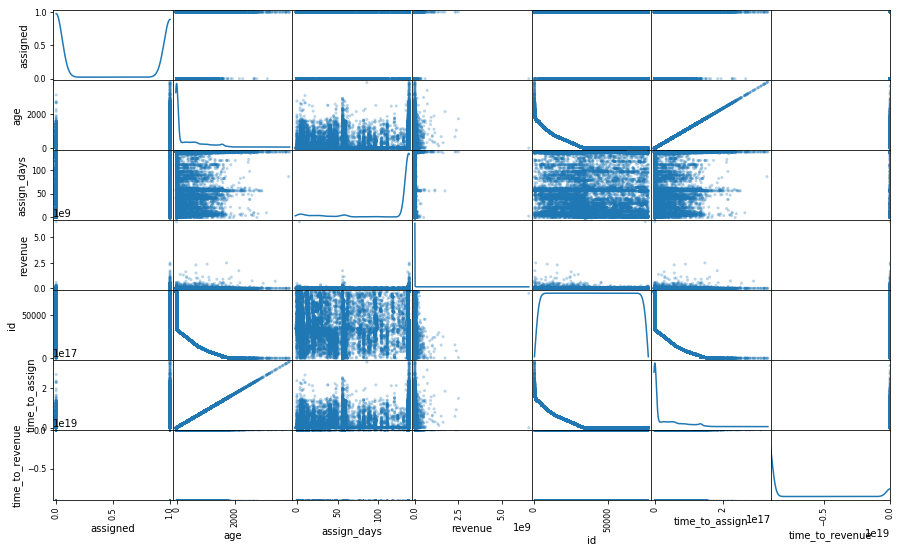

In [6]:
forPlot = data.drop(['advertiser_id','date_assignment_starts','date_assignment_ends','date_created'], axis=1)
pd.plotting.scatter_matrix(forPlot, alpha = 0.3, figsize = (15,9), diagonal = 'kde')
#Looking at the plot we say the the best indicator of being assigned is not revenue but age.

In [7]:
#get a basic sense of the data
display(data.describe())

,advertiser_id,assigned,age,assign_days,revenue,id,time_to_assign,time_to_revenue
count,7.789100e+04,77891.000000,77891.000000,77891.000000,7.789100e+04,77891.000000,7.789100e+04,7.789100e+04
mean,7.924271e+06,0.476037,309.958532,120.482546,2.086209e+06,38945.000000,2.678042e+16,-8.223640e+18
std,3.918985e+06,0.499429,488.801166,39.527908,3.728792e+07,22485.339246,4.223242e+16,2.869181e+18
min,4.850000e+02,0.000000,-27.000000,-2.000000,0.000000e+00,0.000000,-2.332800e+15,-9.223372e+18
25%,4.317428e+06,0.000000,0.000000,136.000000,0.000000e+00,19472.500000,0.000000e+00,-9.223372e+18
50%,1.078788e+07,0.000000,0.000000,137.000000,0.000000e+00,38945.000000,0.000000e+00,-9.223372e+18
75%,1.080747e+07,1.000000,523.000000,138.000000,0.000000e+00,58417.500000,4.518720e+16,-9.223372e+18
max,1.119963e+07,1.000000,3855.000000,138.000000,6.533791e+09,77890.000000,3.330720e+17,2.327616e+17


In [8]:
#Q1 B and C
data.groupby('assigned')['revenue'].describe()
#pd.plotting.scatter_matrix(data.['revenue','age',time_to_revenue','revenue'], alpha = 0.3, figsize = (15,9), diagonal = 'kde')
#its interesting to note that though the revenue in assigned leads is higher the highest revenue advertiser is un assigned

,count,mean,std,min,25%,50%,75%,max
assigned,,,,,,,,
0,40812.0,1.039001e+06,3.322616e+07,0.0,0.0,0.0,0.0,6.533791e+09
1,37079.0,3.238846e+06,4.126909e+07,0.0,0.0,0.0,0.0,2.500000e+09


In [9]:
#Q1 B
data.groupby('assigned')['revenue'].sum()

assigned
0    4.240371e+10
1    1.200932e+11
Name: revenue, dtype: float64

In [10]:
data.groupby('revenue')['assigned'].describe() #Over 74551 leads produce no revenue!

,count,mean,std,min,25%,50%,75%,max
revenue,,,,,,,,
0.000000e+00,74551.0,0.476372,0.499445,0.0,0.00,0.0,1.00,1.0
1.200000e+04,1.0,1.000000,NaN,1.0,1.00,1.0,1.00,1.0
1.300000e+04,1.0,0.000000,NaN,0.0,0.00,0.0,0.00,0.0
1.626700e+04,1.0,1.000000,NaN,1.0,1.00,1.0,1.00,1.0
1.782600e+04,1.0,1.000000,NaN,1.0,1.00,1.0,1.00,1.0
2.100000e+04,1.0,0.000000,NaN,0.0,0.00,0.0,0.00,0.0
2.257300e+04,1.0,1.000000,NaN,1.0,1.00,1.0,1.00,1.0
3.029400e+04,1.0,0.000000,NaN,0.0,0.00,0.0,0.00,0.0
3.371000e+04,1.0,1.000000,NaN,1.0,1.00,1.0,1.00,1.0


first we look at all data


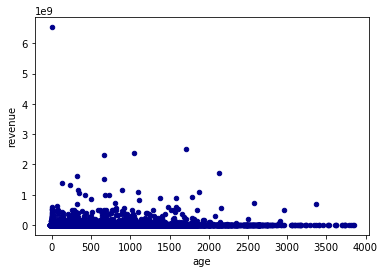

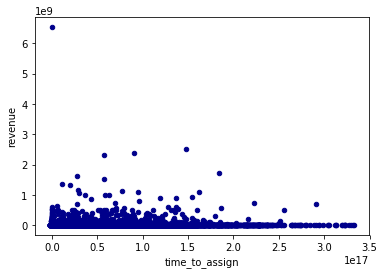

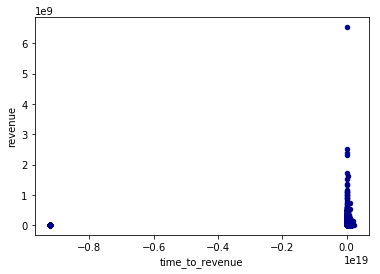

In [11]:
#Q3
print('first we look at all data')
data.plot.scatter(x='age',y='revenue',c='DarkBlue')
data.plot.scatter(x='time_to_assign',y='revenue',c='DarkBlue')
data.plot.scatter(x='time_to_revenue',y='revenue',c='DarkBlue')

now just the revenue generating


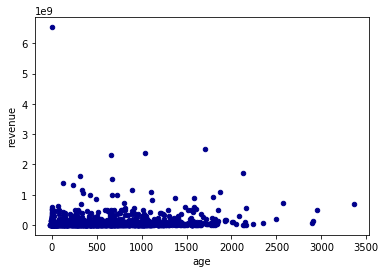

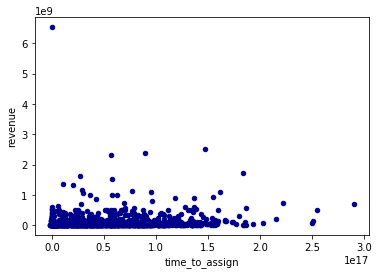

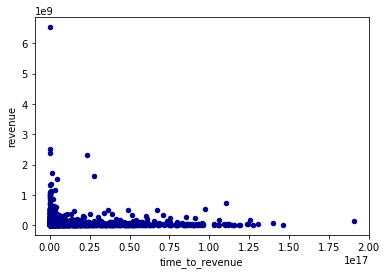

In [12]:
#Q3
print('now just the revenue generating')
revenueGeneratingAccounts = data.loc[data.revenue > 0]
revenueGeneratingAccounts.plot.scatter(x='age',y='revenue',c='DarkBlue')
revenueGeneratingAccounts.plot.scatter(x='time_to_assign',y='revenue',c='DarkBlue')
revenueGeneratingAccounts.plot.scatter(x='time_to_revenue',y='revenue',c='DarkBlue')
#3340 revenue generatign leads

In [13]:
#Q4 All Leads
x = data.assigned
y = data.revenue
model = sm.OLS(y,x).fit()
predictions = model.predict(x)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     279.9
Date:                Wed, 24 Apr 2019   Prob (F-statistic):           1.03e-62
Time:                        13:12:28   Log-Likelihood:            -1.4685e+06
No. Observations:               77891   AIC:                         2.937e+06
Df Residuals:                   77890   BIC:                         2.937e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
assigned    3.239e+06   1.94e+05     16.730      0.000    2.86e+06    3.62e+06
==============================================================================
Omnibus:                   298356.843   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):     553972578481.601
Skew:                          89.086   Prob(JB):                         0.00
Kurtosis:                   13066.686   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
#Q4 Money Generating leads
x = revenueGeneratingAccounts.assigned
y = revenueGeneratingAccounts.revenue
model = sm.OLS(y,x).fit()
predictions = model.predict(x)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     309.5
Date:                Wed, 24 Apr 2019   Prob (F-statistic):           2.52e-66
Time:                        13:12:28   Log-Likelihood:                -68086.
No. Observations:                3340   AIC:                         1.362e+05
Df Residuals:                    3339   BIC:                         1.362e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
assigned    7.674e+07   4.36e+06     17.593      0.000    6.82e+07    8.53e+07
==============================================================================
Omnibus:                     7438.299   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         59943328.171
Skew:                          20.171   Prob(JB):                         0.00
Kurtosis:                     658.060   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
#Q4 for more variables
x = data.drop(['first_revenue_date','id','revenue','advertiser_id','date_assignment_starts','date_assignment_ends','date_created'], axis=1)
y = data.revenue
model = sm.OLS(y,x).fit()
predictions = model.predict(x)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     34.59
Date:                Wed, 24 Apr 2019   Prob (F-statistic):           4.08e-09
Time:                        13:12:29   Log-Likelihood:            -1.4685e+06
No. Observations:               77891   AIC:                         2.937e+06
Df Residuals:                   77889   BIC:                         2.937e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
assigned         9.133e-28   5.47e-29     16.689      0.000    8.06e-28    1.02e-27
age                1.1e-24   6.59e-26     16.689      0.000    9.71e-25    1.23e-24
assign_days      2.243e-26   1.34e-27     16.689      0.000    1.98e-26    2.51e-26
time_to_assign   5.049e-11   3.03e-12     16.689      0.000    4.46e-11    5.64e-11
time_to_revenue  1.364e-13   1.74e-14      7.849      0.000    1.02e-13     1.7e-13
==============================================================================
Omnibus:                   298522.299   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):     557663728921.605
Skew:                          89.239   Prob(JB):                         0.00
Kurtosis:                   13110.139   Cond. No.                     7.83e+21
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.83e+21. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [16]:
#Q4 for more variables only revenue generating
x = revenueGeneratingAccounts.drop(['first_revenue_date','id','revenue','advertiser_id','date_assignment_starts','date_assignment_ends','date_created'], axis=1)
y = revenueGeneratingAccounts.revenue
model = sm.OLS(y,x).fit()
predictions = model.predict(x)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     75.18
Date:                Wed, 24 Apr 2019   Prob (F-statistic):           1.15e-32
Time:                        13:12:29   Log-Likelihood:                -68034.
No. Observations:                3340   AIC:                         1.361e+05
Df Residuals:                    3337   BIC:                         1.361e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
assigned          672.7845     90.874      7.403      0.000     494.609     850.960
age              5595.6027    755.810      7.403      0.000    4113.705    7077.500
assign_days      2.302e+05   3.11e+04      7.403      0.000    1.69e+05    2.91e+05
time_to_assign   1.208e-09   9.99e-11     12.086      0.000    1.01e-09     1.4e-09
time_to_revenue -1.246e-09   1.97e-10     -6.337      0.000   -1.63e-09    -8.6e-10
==============================================================================
Omnibus:                     7520.967   Durbin-Watson:                   2.049
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         66459928.145
Skew:                          20.687   Prob(JB):                         0.00
Kurtosis:                     692.815   Cond. No.                     1.66e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.66e+19. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

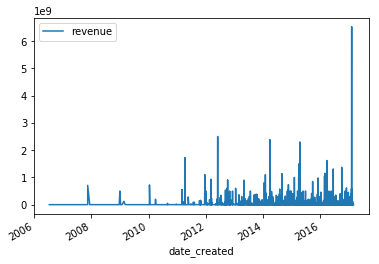

In [17]:
#Q5 Lets look at more data. This time lets focus on time as a factor
revenueAndTime = data.drop(['assign_days','first_revenue_date','assigned','time_to_revenue','time_to_assign','age','id','advertiser_id','date_assignment_starts','date_assignment_ends'], axis=1).set_index("date_created")
revenueAndTime.plot()